IA & Data science (LU3IN026) -- 2019-2020
--------
*&copy; Equipe pédagogique: Gauvain Bourgne, Vincent Guigue, Marie-Jeanne Lesot, Christophe Marsala, Olivier Schwander.*


# TD-TME07: les arbres de décision

L'objectif de ce notebook est d'implémenter un algorithme d'apprentissage supervisé qui travaille sur des données catégorielles, l'algorithme de construction d'arbres de décision.
Pour plus de détails sur cet algorithme, reportez-vous au slides du cours 6 mis en ligne sur le Moodle.


## Préparation du notebook

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

*Braneci sofiane et Hamdad Khellaf*

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>tme-07</tt> et rajouter à la suite de <tt>tme-07</tt> les noms des membres du binômes séparés par un tiret.

Par exemple, pour le binôme Luke Skywalker et Han Solo, le nom de fichier devient `tme-07-Skywalker-Solo`

Penser à sauvegarder fréquemment le fichier en cours de travail :
- soit en cliquant sur l'icône "disquette"
- soit par la combinaison de touches [Ctrl]-S

<font color="RED" size="+1">**[Q]**</font> **Mise à jour de la librairie `iads`**

En premier lieu, vérifier que votre librairie `iads` est bien à jour : 
- dans le fichier `Classifieurs.py`: tous les classifieurs que vous avez implémentés depuis le début des séances. Rajouter aussi dans ce fichier la fonction `leave_one_out` écrite dans le notebook précédent.
- dans le fichier `utils.py`: toutes les fonctions utiles que vous avez implémentées. En particulier, pensez à y mettre la fonction `categories_2_numeriques` ainsi que la classe `AdaptateurCategoriel` du TME précédent. 

Une fois à jour, importer la librairie pour pouvoir l'utiliser dans ce notebook.


In [1]:
# Importation des librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire frère du répertoire courant !

# Importation de la librairie iads
# import iads as iads

# importation de Classifiers
# from iads import Classifiers as cl
import Classifiers as cl

# importation de utils
# from iads import utils as ut
import utils as ut

# importation de evaluation
# from iads import evaluation as ev
import evaluation as ev


Afin de réaliser les premiers essais avec les fonctions que l'on va programmer, on charge la base sur les élections vue dans le cours 6 et que l'on a utilisé dans le notebook précédent (cf. le notebook précédent pour revoir les étapes qui suivent).

In [284]:
# Chargement des fichiers de données :

elections_df = pd.read_csv("elections.csv")
elections_df

,Adresse,Majeur?,Nationalite,Label
0,Paris,oui,Francais,1
1,Paris,non,Francais,-1
2,Montpellier,oui,Italien,1
3,Paris,oui,Suisse,-1
4,Strasbourg,non,Italien,-1
5,Strasbourg,non,Francais,-1
6,Strasbourg,oui,Francais,1
7,Montpellier,oui,Suisse,-1


In [285]:
# Passer du dataframe à des arrays:
elections_desc = np.array(elections_df[['Adresse', 'Majeur?','Nationalite']])
elections_label = np.array(elections_df['Label'])

# obtenir les noms des colonnes :
elections_noms = ['Adresse', 'Majeur?','Nationalite']

print("Noms des features: ",elections_noms)

Noms des features:  ['Adresse', 'Majeur?', 'Nationalite']


## Premières fonctions: entropie et classe majoritaire

<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction <code>classe_majoritaire</code> qui, étant donné un array de labels rend la classe majoritaire (celle qui est possédée par le plus grand nombre d'exemples donc...). En cas d'égalité, cette fonction rend la première classe rencontrée.

**Remarque :** on utilise la fonction numpy `unique` qui permet d'obtenir les valeurs différentes d'un array ainsi que leur décompte.

In [286]:
# Exemple d'utilisation de la fonction numpy `unique`

valeurs, nb_fois = np.unique(elections_label,return_counts=True)

print("Valeurs différentes dans l'array           : ",valeurs)
print("Décompte de chaque valeur (respectivement) : ",nb_fois)

Valeurs différentes dans l'array           :  [-1  1]
Décompte de chaque valeur (respectivement) :  [5 3]


In [ ]:
def classe_majoritaire(Y):
    """ Y : (array) : array de labels
        rend la classe majoritaire ()
    """
    values, counts = np.unique(Y, return_counts=True)
    return values[counts.argmax()]
    #### A compléter pour répondre à la question posée

In [288]:
#Vérification sur nos données:
classe_majoritaire(elections_label)

-1

### Entropie et gain d'information

On note $\{c_1, c_2,..., c_k\}$, l'ensemble des classes possibles.

Dans le cours, la mesure de désordre présentée utilise, pour toute valeur $c$ de la classe le ratio $\frac{\mbox{nombre de } c \mbox{ dans } Y}{|Y|}$ qui correspond à la probabilité de la classe $c$ parmi $Y$.
On note dans ce qui suit $p_1$ la probabilité de la classe $c_1$ parmi $Y$, etc. 

Ainsi, on a $P=(p_1, p_2,..., p_k)$ la distribution de probabilités sur les classes ainsi définies.

L'**entropie de Shannon** de la distribution $P$ est donnée par:

$ H_S(P) = -\sum_{i=1}^{k} p_i \log_k(p_i)$

Le logarithme utilisé est le logarithme en base $k$ afin d'obtenir une valeur comprise entre $0$ et $1$ de l'entropie. 

Pour ce qui suit, une *distribution de probabilités* est représentée par une **liste** Python $P=[p_1,...,p_k]$ de valeurs réelles telle que
* pour tout $i=1,..., k$ : $0 \leq p_i \leq 1$
* $\sum_{i=1}^{k}p_i = 1$


<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction `shannon` qui, étant donné une distribution de probabilités $P$ fournie sous la forme d'une liste de nombres, rend la valeur de $H_S(P)$, l'entropie de Shannon de $P$.

In [ ]:
import math
def shannon(P):
    """ list[Number] -> float
        Hypothèse: la somme des nombres de P vaut 1
        P correspond à une distribution de probabilité
        rend la valeur de l'entropie de Shannon correspondante
    """
    #### A compléter pour répondre à la question posée
    base = len(P)
    e = 0.0
    if base == 1:
        return 0.0
    for p in P:
        if p == 0: continue
        e -= p * math.log(p, base)
    return e

In [290]:
print("H([1]) = ", shannon([1]))

H([1]) =  0.0


In [291]:
# Exemples d'utilisation:
print("H([1]) = ", shannon([1]))
print("H([1,0]) = ", shannon([1, 0]))
print("H([0.25, 0.25, 0.25, 0.25]) = ", shannon([0.25, 0.25, 0.25, 0.25]))
print("H([0.7, 0.1, 0.2, 0.0]) = ", shannon([0.7, 0.1, 0.2, 0.0]))
print("H([1.0/3, 2.0/3]) = ", shannon([1.0/3, 2.0/3]))

H([1]) =  0.0
H([1,0]) =  0.0
H([0.25, 0.25, 0.25, 0.25]) =  1.0
H([0.7, 0.1, 0.2, 0.0]) =  0.5783898247235197
H([1.0/3, 2.0/3]) =  0.9182958340544896


<font color="RED" size="+1">**[Q]**</font> Tracer, à l'aide de la fonction `plot`, la courbe donnant la valeur de `shannon([p, 1-p])` en fonction de `p`.

In [ ]:
# Pour plot, on a besoin de la librairie suivante:
import matplotlib.pyplot as plt

Text(0, 0.5, 'shannon([p, 1-p])')

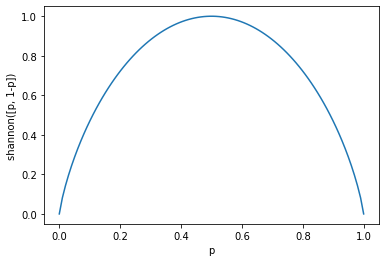

In [293]:
# Tracé de la courbe:

## A COMPLETER
P = np.linspace(0,1,100)
values = []
for p in P:
    values.append(shannon([p, 1-p]))
plt.plot(P, values)
plt.xlabel('p')
plt.ylabel('shannon([p, 1-p])')


<font color="RED" size="+1">**[Q]**</font> A l'aide de la fonction <code>shannon</code>, écrire la fonction <code>entropie</code> qui prend un ensemble de labels en argument et renvoie l'entropie de la distribution des classes dans cet ensemble.

In [ ]:
def entropie(lables):
  # print(lables)
    values, counts = np.unique(lables, return_counts=True)
    probs = counts / sum(counts)
  # print(probs, sum(probs))
    return shannon(probs)

In [295]:
elections_label

array([ 1, -1,  1, -1, -1, -1,  1, -1])

In [296]:
# Exemple sur nos données :
entropie(elections_label)

0.9544340029249649

## Arbres de décision

Dans cette partie, on réalise l'implémentation de l'algorithme de construction d'un arbre de décision.

### Représentation d'un arbre en Python

Pour représenter un arbre en Python, on a besoin de définir une structure de données adéquate. 

Un arbre de décision est défini par des **noeuds** qui sont de 2 types :
- *noeud interne* : c'est un noeud qui est associé à un attribut (ie. une feature de description des exemples) et qui possède des fils qui sont aussi des noeuds. 
- *feuille* : c'est un noeud qui est associé à un label de la classe et qui a la particularité de ne pas avoir de descendants.

Pour représenter des noeuds, nous définissons la classe `NoeudCategoriel` suivante:

In [ ]:
# La librairie suivante est nécessaire pour l'affichage graphique de l'arbre:
import graphviz as gv

# Pour plus de détails : https://graphviz.readthedocs.io/en/stable/manual.html

# Eventuellement, il peut être nécessaire d'installer graphviz sur votre compte:
# pip install --user --install-option="--prefix=" -U graphviz

class NoeudCategoriel:
    """ Classe pour représenter des noeuds d'un arbre de décision
    """
    def __init__(self, num_att=-1, nom=''):
        """ Constructeur: il prend en argument
            - num_att (int) : le numéro de l'attribut auquel il se rapporte: de 0 à ...
              si le noeud se rapporte à la classe, le numéro est -1, on n'a pas besoin
              de le préciser
            - nom (str) : une chaîne de caractères donnant le nom de l'attribut si
              il est connu (sinon, on ne met rien et le nom sera donné de façon 
              générique: "att_Numéro")
        """
        self.attribut = num_att    # numéro de l'attribut
        if (nom == ''):            # son nom si connu
            self.nom_attribut = 'att_'+str(num_att)
        else:
            self.nom_attribut = nom 
        self.Les_fils = None       # aucun fils à la création, ils seront ajoutés
        self.classe   = None       # valeur de la classe si c'est une feuille
        
    def est_feuille(self):
        """ rend True si l'arbre est une feuille 
            c'est une feuille s'il n'a aucun fils
        """
        return self.Les_fils == None
    
    def ajoute_fils(self, valeur, Fils):
        """ valeur : valeur de l'attribut de ce noeud qui doit être associée à Fils
                     le type de cette valeur dépend de la base
            Fils (NoeudCategoriel) : un nouveau fils pour ce noeud
            Les fils sont stockés sous la forme d'un dictionnaire:
            Dictionnaire {valeur_attribut : NoeudCategoriel}
        """
        if self.Les_fils == None:
            self.Les_fils = dict()
        self.Les_fils[valeur] = Fils
        # Rem: attention, on ne fait aucun contrôle, la nouvelle association peut
        # écraser une association existante.
    
    def ajoute_feuille(self,classe):
        """ classe: valeur de la classe
            Ce noeud devient un noeud feuille
        """
        self.classe    = classe
        self.Les_fils  = None   # normalement, pas obligatoire ici, c'est pour être sûr
        
    def classifie(self, exemple):
        """ exemple : numpy.array
            rend la classe de l'exemple (pour nous, soit +1, soit -1 en général)
            on rend la valeur 0 si l'exemple ne peut pas être classé (cf. les questions
            posées en fin de ce notebook)
        """
        if self.est_feuille():
            return self.classe
        if exemple[self.attribut] in self.Les_fils:
            # descente récursive dans le noeud associé à la valeur de l'attribut
            # pour cet exemple:
            return self.Les_fils[exemple[self.attribut]].classifie(exemple)
        else:
            # Cas particulier : on ne trouve pas la valeur de l'exemple dans la liste des
            # fils du noeud... Voir la fin de ce notebook pour essayer de résoudre ce mystère...
            print('\t*** Warning: attribut ',self.nom_attribut,' -> Valeur inconnue: ',exemple[self.attribut])
            return 0
    
    def to_graph(self, g, prefixe='A'):
        """ construit une représentation de l'arbre pour pouvoir l'afficher graphiquement
            Cette fonction ne nous intéressera pas plus que ça, elle ne sera donc pas expliquée            
        """
        if self.est_feuille():
            g.node(prefixe,str(self.classe),shape='box')
        else:
            g.node(prefixe, self.nom_attribut)
            i =0
            for (valeur, sous_arbre) in self.Les_fils.items():
                sous_arbre.to_graph(g,prefixe+str(i))
                g.edge(prefixe,prefixe+str(i), valeur)
                i = i+1        
        return g


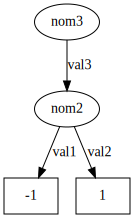

In [298]:
# Exemple d'utilisation: 
un_noeud0= NoeudCategoriel() 
un_noeud0.ajoute_feuille(-1)

un_noeud1= NoeudCategoriel()
un_noeud1.ajoute_feuille(+1)

un_noeud2= NoeudCategoriel(0,"nom2")
un_noeud2.ajoute_fils("val1",un_noeud0)
un_noeud2.ajoute_fils("val2",un_noeud1)

un_noeud3 = NoeudCategoriel(1,"nom3")
un_noeud3.ajoute_fils("val3",un_noeud2)

# L'affichage se fait en 2 temps
# 1) on initialise un graphe orienté :
gtree = gv.Digraph(format='png')
# 2) on le rempli en appelant la méthode de la classe NoeudCategoriel
un_noeud3.to_graph(gtree)

### Construction de l'arbre de décision

Comme on l'a vu dans le cours 6, pour construire un arbre de décision à partir d'un dataset ($X$, $Y$), il faut réaliser les étapes suivantes:
1. calculer l'entropie de Shannon de l'ensemble des classes $Y$, on la note $H_S(Y)$.
2. si $H_S(Y)$ est inférieure à epsilon (qui est un réel positif donné en paramètre de l'algorithme), alors construire une feuille avec cet ensemble, la classe associée à cette feuille est la classe majoritaire dans $Y$.
3. sinon, pour chaque attribut $X_j$ qui décrit les exemples de $X$,
    - 3.1. pour chacune des valeurs $v_{jl}$ de $X_j$ construire l'ensemble des exemples de $X$ qui possède la valeur $v_{jl}$ ainsi que l'ensemble de leurs labels.
    - 3.2. calculer l'entropie conditionnelle de Shannon de la classe relativement à l'attribut $X_j$. On note $H_S(Y|X_j)$ cette entropie.
4. l'attribut $X_{best}$ qui **maximise le gain d'information** est choisi pour constituer un nouveau noeud $\eta$ de l'arbre de décision:
    - 4.1. chaque valeur de $X_{best}$ est utilisée pour décomposer ($X$, $Y$) en autant de datasets que $X_{best}$ possède de valeurs: chaque dataset est séparant $X$ et $Y$ selon la valeur prise pour $X_{best}$. 
    - 4.2. pour chaque dataset obtenu on reprend en 1 pour construire chacun des fils de $\eta$. 


On rappelle (cf. cours 6) que le gain d'information vaut:

$$I_S(X_j,Y) = H_S(Y) - H_S(Y|X_j)$$


**Remarque importante:** étant donné que $H_S(Y)$ est la même pour tout les $X_j$, chercher $X_j$ qui maximise le gain d'information est équivalent à chercher $X_j$ qui **minimise la valeur de l'entropie $H_S(Y|X_j)$**.

<font color="RED" size="+1">**[Q]**</font> Compléter la fonction `construit_AD`suivante afin qu'elle permette de construire un arbre de décision. Cette fonction rend un `NoeudCategoriel` qui correspon à l'arbre construit pour le dataset $(X,Y)$ donné.

In [ ]:
def construit_AD(X,Y,epsilon,LNoms = []):
    """ X,Y : dataset
        epsilon : seuil d'entropie pour le critère d'arrêt 
        LNoms : liste des noms de features (colonnes) de description 
    """
    
    entropie_ens = entropie(Y)
    if (entropie_ens <= epsilon):
        # ARRET : on crée une feuille
        noeud = NoeudCategoriel(-1,"Label")
        noeud.ajoute_feuille(classe_majoritaire(Y))
    else:
        min_entropie = 1.1
        i_best = -1
        Xbest_valeurs = None
        
        ############################# DEBUT ########
        
        # COMPLETER CETTE PARTIE : ELLE DOIT PERMETTRE D'OBTENIR DANS
        # i_best : le numéro de l'attribut qui minimise l'entropie
        # min_entropie : la valeur de l'entropie minimale
        # Xbest_valeurs : la liste des valeurs que peut prendre l'attribut i_best
        #
        # Il est donc nécessaire ici de parcourir tous les attributs et de calculer
        # la valeur de l'entropie de la classe pour chaque attribut.
        Xbest_valeurs = []
        for i in range(len(LNoms)):
            values, counts = np.unique(X[:, i], return_counts=True)
            pAtt = counts / sum(counts)
          # entropy conditionnelle
            e = 0
            for val in range(len(values)):
                mask = (X[:, i] == values[val])
                e+= entropie(Y[mask]) * pAtt[val]
            if min_entropie > e:
                Xbest_valeurs = values
                min_entropie = e
                i_best = i
        
        ############################# FIN ######## 
        
        if len(LNoms)>0:  # si on a des noms de features
            noeud = NoeudCategoriel(i_best,LNoms[i_best])    
        else:
            noeud = NoeudCategoriel(i_best)
        for v in Xbest_valeurs:
            noeud.ajoute_fils(v,construit_AD(X[X[:,i_best]==v], Y[X[:,i_best]==v],epsilon,LNoms))
    return noeud

In [ ]:
root = construit_AD(elections_desc, elections_label, 0.0, elections_noms)

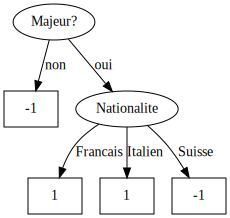

In [301]:
gtree = gv.Digraph(format='png')
# 2) on le rempli en appelant la méthode de la classe NoeudCategoriel
root.to_graph(gtree)

La classe pour implémenter un arbre de décision dérive de la classe `Classifier`. Elle utilise la fonction `construit_AD` dans sa méthode `train` pour construire un arbre à partir d'un dataset donné.

<font color="RED" size="+1">**[Q]**</font> Compléter la classe suivante en donnant le code des méthodes `train` et `predict`.

**Remarque :** la méthode `score` ne fera rien dans notre cas, on verra dans un autre notebook comment on pourrait la définir.

In [ ]:
class ClassifierArbreDecision(cl.Classifier):
    """ Classe pour représenter un classifieur par arbre de décision
    """
    
    def __init__(self, input_dimension, epsilon, LNoms=[]):
        """ Constructeur
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
                - epsilon (float) : paramètre de l'algorithme (cf. explications précédentes)
                - LNoms : Liste des noms de dimensions (si connues)
            Hypothèse : input_dimension > 0
        """
        self.dimension = input_dimension
        self.epsilon = epsilon
        self.LNoms = LNoms
        # l'arbre est manipulé par sa racine qui sera un Noeud
        self.racine = None
        
    def toString(self):
        """  -> str
            rend le nom du classifieur avec ses paramètres
        """
        return 'ClassifierArbreDecision ['+str(self.dimension) + '] eps='+str(self.epsilon)
        
    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        ##################
        ## COMPLETER ICI !
        ##################
        self.racine = construit_AD(desc_set, label_set, self.epsilon,self.LNoms)
    
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        # cette méthode ne fait rien dans notre implémentation :
        pass
    
    def predict(self, x):
        """ x (array): une description d'exemple
            rend la prediction sur x             
        """
        ##################
        ## COMPLETER ICI !
        ##################
        return self.racine.classifie(x)

    def affiche(self,GTree):
        """ affichage de l'arbre sous forme graphique
            Cette fonction modifie GTree par effet de bord
        """
        self.racine.to_graph(GTree)

### Premières expérimentations

Apprentissage d'un arbre de décision avec la base sur les élections :

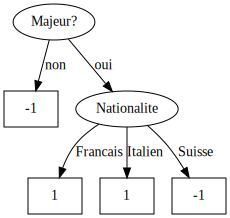

In [303]:
# Initialiation d'un arbre pour le dataset Elections:
arbre_elections = ClassifierArbreDecision(len(elections_noms), 0.0, elections_noms)

# Construction de l'arbre de décision à partir du dataset Elections
arbre_elections.train(elections_desc,elections_label)

# Construction de la représentation graphique (affichage)
graphe_arbre_elections = gv.Digraph(format='png')
arbre_elections.affiche(graphe_arbre_elections)

# Affichage du graphe obtenu:
graphe_arbre_elections

Pour classer un nouvel exemple avec un arbre de décision, on utilise la méthode <code>predict</code> qui utilise la méthode `classifie` de la classe `NoeudCategoriel` pour classer un nouvel exemple et renvoyer le label +1 ou -1 selon le cas. 

Exemple de classification d'un exemple avec l'arbre obtenu :

In [304]:
arbre_elections.predict(elections_desc[0,:])

1

Classification d'un nouvel exemple qui n'appartient à pas au dataset d'apprentissage :

In [305]:
# Rappel : elections_noms = ['Adresse', 'Majeur?', 'Nationalite']
arbre_elections.predict(np.array(['Paris','oui','Italien']))

1

Mesure de l'accuracy de l'arbre obtenu :

In [306]:
arbre_elections.accuracy(elections_desc,elections_label)

100.0

## Première expérimentation avec la base Mushrooms

Pour mieux évaluer notre nouvel algortithme d'apprentissage, on va utiliser la base des champignons (mushrooms) que l'on a vu dans le notebook précédent.

Dans le répertorie `data/` fourni avec ce sujet, vous pouvez trouver 6 fichiers `mushrooms-****.csv`. Ces 6 fichiers ont été obtenus en partitionant le fichier orignal `mushrooms.csv` que l'on peut trouver sur internet. Dans cette base originale, il y a 8124 champignons recensés. Ce fichier original a été découpé en 5 fichiers de 1400 champignons et 1 fichier de 1124 champignons. L'union de ces 6 fichiers permet donc de recomposer le fichier original.


### Construction d'un arbre de décision

Dans un premier temps, on vérifie que notre algorithme d'apprentissage fonctionne correctement en construisant un arbre de décision à partir d'un des fichiers.

On commence par charger le fichier dans un dataframe et on le transforme en dataset (cf. le notebook précédent pour le détail des étapes):

In [ ]:
# Chargement des fichiers de données sur les mushrooms:

# On commence par travailler sur un des fichier "mushrooms-1400"
mushrooms_df = pd.read_csv("mushrooms-1400-1.csv")

# Comme lors du TME-06, On remplace la colonne 'class' par une colonne 'Label' en remplaçant
# les valeurs de classes par +1 et -1 (cf. le TME-06 si vous avez oublié...)
mushrooms_df['Label'] = 0
for i in mushrooms_df.index:
    if mushrooms_df.loc[i,'class'] == 'e':
        mushrooms_df.loc[i,'Label'] = 1
    else:
        mushrooms_df.loc[i,'Label'] = -1
del mushrooms_df['class']   

# noms des colonnes (on peut les récupérer directement):
mushrooms_noms = ['cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment',
                  'gill-spacing','gill-size','gill-color','stalk-shape','stalk-root',
                  'stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring',
                  'stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type',
                  'spore-print-color','population','habitat']

# Passer du dataframe à un dataset (2 arrays):
mushrooms_1_desc = np.array(mushrooms_df[mushrooms_noms])
mushrooms_1_label = np.array(mushrooms_df['Label'])


In [308]:
mushrooms_df.head()
print()
mushrooms_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 23 columns):
cap-shape                   1400 non-null object
cap-surface                 1400 non-null object
cap-color                   1400 non-null object
bruises                     1400 non-null object
odor                        1400 non-null object
gill-attachment             1400 non-null object
gill-spacing                1400 non-null object
gill-size                   1400 non-null object
gill-color                  1400 non-null object
stalk-shape                 1400 non-null object
stalk-root                  1400 non-null object
stalk-surface-above-ring    1400 non-null object
stalk-surface-below-ring    1400 non-null object
stalk-color-above-ring      1400 non-null object
stalk-color-below-ring      1400 non-null object
veil-type                   1400 non-null object
veil-color                  1400 non-null object
ring-number                 1400 non-null object
ring-type 

Ensuite, on construit l'arbre de décision correspondant.

<font color="RED" size="+1">**[Q]**</font> Compléter le code suivant pour apprendre l'arbre et l'afficher ensuite:

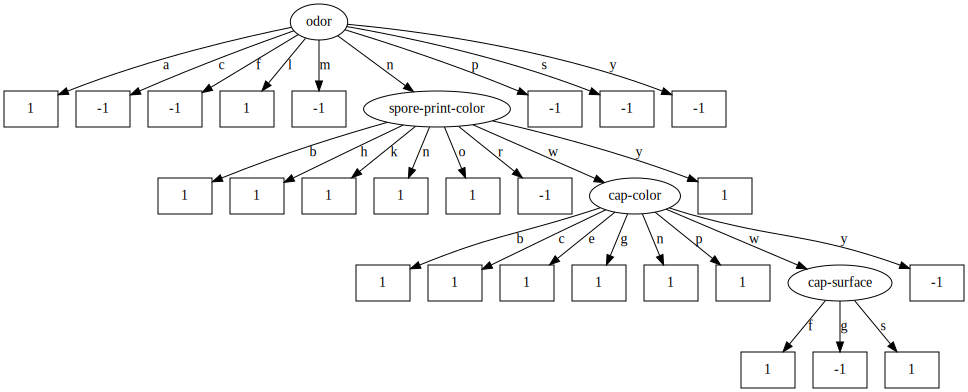

In [309]:
# construction de l'arbre de décision à partir du dataset Elections:
arbre_mushrooms_1 = ClassifierArbreDecision(len(mushrooms_noms), 0.0, mushrooms_noms)

#################################
arbre_mushrooms_1.train(mushrooms_1_desc, mushrooms_1_label)
gr_arbre_mushrooms_1 = gv.Digraph(format='png')
arbre_mushrooms_1.affiche(gr_arbre_mushrooms_1)

#################################


# Affichage du graphe obtenu:
gr_arbre_mushrooms_1

### Classification avec l'arbre de décision obtenu

Exemple de classification d'un exemple:

In [310]:
arbre_mushrooms_1.predict(mushrooms_1_desc[0,:])

-1

Calcul de l'accuracy sur le dataset d'apprentissage :

In [311]:
arbre_mushrooms_1.accuracy(mushrooms_1_desc,mushrooms_1_label)

100.0

<font color="RED" size="+1">**[Q]**</font> Toujours avec le dataset `mushrooms_1` précédent, construire un nouvel arbre de décision en utilisant comme valeur d'epsilon : $0.25$.

Que constatez-vous ? 

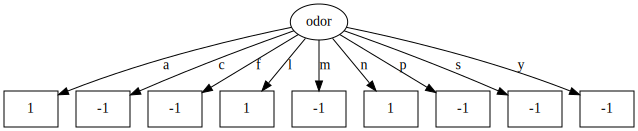

In [312]:
#################################

tree = ClassifierArbreDecision(len(mushrooms_noms), 0.25, mushrooms_noms)
tree.train(mushrooms_1_desc, mushrooms_1_label)
#################################
gr_arbre_mushrooms_1_bis = gv.Digraph(format='png')
tree.affiche(gr_arbre_mushrooms_1_bis)

# Affichage du graphe obtenu:
gr_arbre_mushrooms_1_bis

<font color="RED" size="+1">**[Q]**</font> Déterminer l'accuracy de ce nouvel arbre.

In [313]:
tree.accuracy(mushrooms_1_desc,mushrooms_1_label)

98.92857142857143

<font color="RED" size="+1">**[Q]**</font> D'après ces résultats, de ces 2 arbres, quel est celui qui a sur-appris ? 

En se basant uniquement sur l'accuracy et la taille des arbres, alors on remarque bien que le 1er modèle est en sur-appritissage.
Mais cela n'est la  bonne méthode pour affirmer qu'un modèle est en sur-apprentissage, il faudrait utiliser la cross validation.

## Plus d'expérimentations avec la base Mushrooms

On décide maintenant d'évaluer plus en détail ce nouvel algorithme. On souhaite:
1. construire un arbre avec chaque fichier `mushrooms-1400-*.csv` 
2. pour chaque arbre construit, évaluer son accuracy:
    - sur le dataset d'apprentissage
    - sur les 4 autres fichiers `mushrooms-1400-*.csv`
    - sur le fichier `mushrooms-1124.csv`
    
    
**Remarque :** normalement, tous ces tests devraient pouvoir se faire dans un temps raisonnable, dans le cas contraire, faites les un par un.

In [ ]:
# noms des colonnes (on peut les récupérer directement):
mushrooms_noms = ['cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment',
                  'gill-spacing','gill-size','gill-color','stalk-shape','stalk-root',
                  'stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring',
                  'stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type',
                  'spore-print-color','population','habitat']

# Chargement des fichiers mushrooms et apprentissage
mushrooms_desc = []
mushrooms_label = []
arbres_mushrooms = []
for j in range(0,5):
    mushrooms_df = pd.read_csv("mushrooms-1400-"+str(j+1)+".csv")
    # Conversion des labels
    mushrooms_df['Label'] = 0
    for i in mushrooms_df.index:
        if mushrooms_df.loc[i,'class'] == 'e':
            mushrooms_df.loc[i,'Label'] = 1
        else:
            mushrooms_df.loc[i,'Label'] = -1
    del mushrooms_df['class']   
    # Passer du dataframe à un dataset (2 arrays):
    mushrooms_desc.append(np.array(mushrooms_df[mushrooms_noms]))
    mushrooms_label.append(np.array(mushrooms_df['Label']))
    
    # Apprentissage
    arbres_mushrooms.append(ClassifierArbreDecision(len(mushrooms_noms), 0.0, mushrooms_noms))
    arbres_mushrooms[j].train(mushrooms_desc[j],mushrooms_label[j])

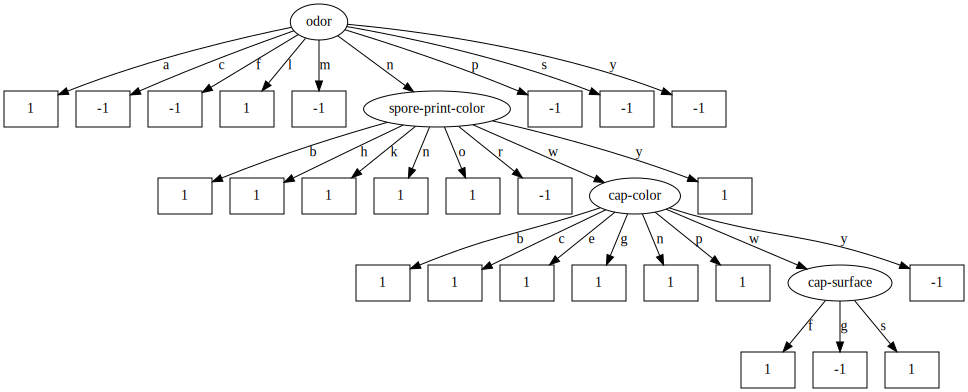

In [315]:
gr = gv.Digraph(format='png')
arbres_mushrooms[0].affiche(gr)
gr

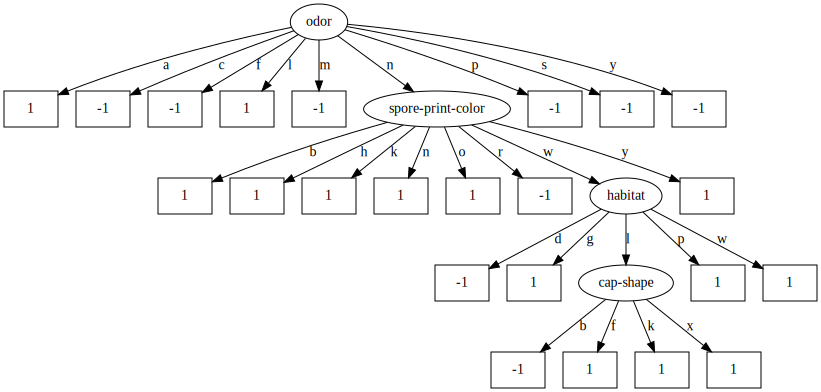

In [316]:
gr = gv.Digraph(format='png')
arbres_mushrooms[2].affiche(gr)
gr

In [ ]:
# Fichier qui va nous servir à tester
mushrooms_df = pd.read_csv("mushrooms-1124.csv")
# Conversion des labels
mushrooms_df['Label'] = 0
for i in mushrooms_df.index:
    if mushrooms_df.loc[i,'class'] == 'e':
        mushrooms_df.loc[i,'Label'] = 1
    else:
        mushrooms_df.loc[i,'Label'] = -1
del mushrooms_df['class']   
# Passer du dataframe à un dataset (2 arrays):
mushrooms_test_desc = np.array(mushrooms_df[mushrooms_noms])
mushrooms_test_label = np.array(mushrooms_df['Label'])

<font color="RED" size="+1">**[Q]**</font> Donner les instructions permettant d'obtenir le taux de bonne classification (accuracy) de chacun des arbres construits sur les autres bases, sur le modèle suivant:

In [318]:
for i in range(len(arbres_mushrooms[:])):
    model = arbres_mushrooms[i]
  # model.train(mushrooms_desc[i], mushrooms_label[i])
    print('Appritissage avec mushrooms-1400-'+str(i+1))
    for j in range(len(mushrooms_desc)):
        label = mushrooms_label[j]
        data = mushrooms_desc[j]
        print('\tclassification  de mushrooms-1400-'+str(j+1)+ ' : '+ str(model.accuracy(data, label)))
    print('\t-->classification de mushroom-1124 :' + str(model.accuracy(mushrooms_test_desc,mushrooms_test_label )))

Appritissage avec mushrooms-1400-1
	classification  de mushrooms-1400-1 : 100.0
	classification  de mushrooms-1400-2 : 100.0
	classification  de mushrooms-1400-3 : 99.64285714285714
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
	classification  de mushrooms-1400-4 : 99.57142857142857
	classification  de mushrooms-1400-5 : 99.71428571428571
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
	-->classification de mushroom-1124 :99.55516014234875
Appritissage avec mushrooms-1400-2
	classification  de mushrooms-1400-1 : 99.85714285714286
	classification  de mushrooms-1400-2 : 100.0
	classification  de mushrooms-1400-3 : 99.64285714285714
	classification  de mushrooms-1400-4 : 99.57142857142857
	classification  de mushrooms-1400-5 : 99.64285714285714
	-->classification de mushroom-1124 :99.4661921708185
Appritissage avec mushrooms-1400-3
	classificat

<font color="RED" size="+1">**[Q]**</font> On peut remarquer que pour certains arbres, la classification de certains exemples produit un warning.
En étudiant les exemples suivant et leur classification par le premier arbre, expliquez pourquoi un warning se produit.
Est-ce normal ? Pourrait-on trouver une solution pour ces cas-là ?


<font color='red'>Réponse</font>

Cela est pricipalement lié à la notion de gain d'information, par construction ID3 cherche à maxmiser le gain d'information, lorsque le temps est venu de traiter l'attribut son gain d'information étais minimal, de ce fait il n'a pas étais inclue dans l'arbre de décision. 

In [319]:
for i in range(0,1400):
    prediction = arbres_mushrooms[0].predict(mushrooms_desc[3][i,:])
    if prediction == 0:
        print(i," --> pas de prédiction, le label rendu est ",prediction)


	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
962  --> pas de prédiction, le label rendu est  0
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
1219  --> pas de prédiction, le label rendu est  0
	*** Warning: attribut  cap-surface  -> Valeur inconnue:  y
1349  --> pas de prédiction, le label rendu est  0


<font color="RED" size="+1">**[Q]**</font> Regrouper les 6 fichiers mushrooms et réaliser une évaluation de l'algorithme de construction d'arbres en utilisant votre fonction `crossvalidation` écrite lors du TDTME 5.

In [ ]:
def transform(df):
    df_copy = df.copy()
    df_copy['Labels'] = 0
    df_copy.loc[df['class']== 'e', 'Labels'] = 1
    df_copy.loc[df['class']== 'p', 'Labels'] = -1
    del df_copy['class']
    return df_copy


In [ ]:
files = ['mushrooms-1400-1.csv','mushrooms-1400-2.csv', 
         'mushrooms-1400-3.csv', 'mushrooms-1400-4.csv', 'mushrooms-1400-5.csv', 'mushrooms-1124.csv']
dfs = [pd.read_csv(name) for name in files]
df = pd.concat(dfs, axis=0)


In [ ]:
transformed = transform(df)
transformed.head()
full_data = np.array(transformed.drop('Labels', axis=1))
full_labels = np.array(transformed['Labels'])
dt = ClassifierArbreDecision(len(mushrooms_noms), 0.0, mushrooms_noms) 
d = ev.cross_validation([dt], full_data, full_labels, k=250)

In [323]:
d

{'ClassifierArbreDecision': {'test_acc': 100.0,
  'test_std': 0.0,
  'train_acc': 100.0,
  'train_std': 0.0}}

### Comparaison avec d'autres algorithmes

<font color="RED" size="+1">**[Q]**</font> Réaliser un ensemble d'expérimentations sur la base mushrooms permettant de comparer les résultats obtenus avec un classifieur par arbres de décision et les classifieurs numériques que l'on a définis dans les séances précédentes.

In [ ]:
from utils import categories_2_numeriques
adapt = ut.AdaptateurCategoriel(transformed, 'Labels')

In [ ]:
knn = cl.ClassifierKNN(adapt.dimension, 50)

On constate que KNN prend énormement de temps sur ce dataset, vue qu'il utilise une métrique de distance

In [326]:
adapt.train(knn)
adapt.accuracy(knn)

99.85228951255539

In [327]:
per = cl.ClassifierPerceptron(adapt.dimension, 0.1)
adapt.train(per)
adapt.accuracy(per)

97.82127031019202

Conclusion

On remarque que l'arbre de décision est bien plus robust et plus rapide à entrainer que KNN